In [441]:
# Import necessary libraries.
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kstest
import numpy as np
import scipy.stats as spstats
from scipy.stats import shapiro
from sklearn.preprocessing import *
import warnings
from sklearn import linear_model

%matplotlib inline
warnings.filterwarnings('ignore')

In [423]:
# Read in data for test.
data = pd.read_csv('data/Pokemon.csv')
data = data.drop(labels='#', axis=1)

In [369]:
# Explore data.
data[0:3]

,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False


In [424]:
# Detect the category data columns, as well as numerical columns in dataframe.
id_columns = ['Name']
target_column = ['Legendary']
cate_columns = []
num_columns = []
for key in data.dtypes.keys():
    if key in id_columns or key in target_column:
        continue
    if data.dtypes[key] not in ['float', 'int']:
        cate_columns.append(key)
        data[key] = data[key].astype('object')
    else:
        num_columns.append(key)

### Numerical Data Column.

In [425]:
# Fill None with 'mean' for numerical columns.
imputer = Imputer()
imputer.fit(data[num_columns])
data[num_columns] = imputer.transform(data[num_columns])

In [426]:
# Convert values in numerical columns to positive values, if there are some negative values.
for column in num_columns:
    if sum(data[column] <= 0) != 0:
        if min(data[column]) == 0:
            data[column] = data[column] + max(data[column]) * 0.01
        else:
            data[column] = data[column] - min(data[column]) * 1.01

In [427]:
# Convert numerical columns whose distributions are not normal to normal distribution.
# Check whether the distribution is normal or not.
for column in num_columns:
    # normality test
    stat, p = shapiro(data['Attack'])
    print(column, ': Statistics=%.3f, p=%.3f' % (stat, p)),
    # interpret
    alpha = 0.05
    # When p-value is under 0.05, it means the distribution is different to normal distribution.
    if p < alpha:
        print('Sample does not look Gaussian (reject H0)'),
        # Calculate skewness of distribution.
        skewness = data[column].skew(axis=0)
        # get optimal lambda value from non null income values
        middle = np.array(data[column])
        middle_clean = middle[~np.isnan(middle)]
        l, opt_lambda = spstats.boxcox(middle_clean)
        print('Optimal lambda value:', opt_lambda)
        data[column] = spstats.boxcox(data[column], lmbda=opt_lambda)
    else:
        print('Sample looks Gaussian (fail to reject H0)')

('Total', ': Statistics=0.979, p=0.000') Sample does not look Gaussian (reject H0) ('Optimal lambda value:', 0.6711935643597299)
('HP', ': Statistics=0.979, p=0.000') Sample does not look Gaussian (reject H0) ('Optimal lambda value:', 0.3991896656578383)
('Attack', ': Statistics=0.979, p=0.000') Sample does not look Gaussian (reject H0) ('Optimal lambda value:', 0.5613020994213337)
('Defense', ': Statistics=0.997, p=0.142') Sample looks Gaussian (fail to reject H0)
('Sp. Atk', ': Statistics=0.997, p=0.142') Sample looks Gaussian (fail to reject H0)
('Sp. Def', ': Statistics=0.997, p=0.142') Sample looks Gaussian (fail to reject H0)
('Speed', ': Statistics=0.997, p=0.142') Sample looks Gaussian (fail to reject H0)
('Generation', ': Statistics=0.997, p=0.142') Sample looks Gaussian (fail to reject H0)


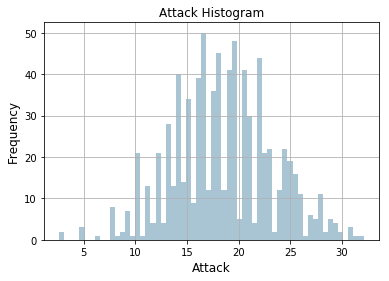

In [428]:
# Plot distribution.
fig, ax = plt.subplots()
data['Attack'].hist(color='#A9C5D3', bins=60)
ax.set_title('Attack Histogram', fontsize=12)
ax.set_xlabel('Attack', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)

In [429]:
# Standarzation.
scaler = StandardScaler()
scaler.fit(data[num_columns])
data[num_columns] = scaler.transform(data[num_columns])

In [430]:
# Round the number into .3float, to lower running time.
data = data.round(3)

In [147]:
# ？？
# Normalization to [0, 1], using Max-min method.
parameter_dic = {}
for column in num_columns:
    max_num = max(data[column])
    min_num = min(data[column])
    parameter_dic[column] = [max_num, min_num]
    # Convert number into suitable format.
    data[column] = (data[column]-min_num)/float(max_num-min_num)

### Category data columns.

In [431]:
# Fill None with 'missing' for category columns.
data[cate_columns] = data[cate_columns].fillna('missing')

In [385]:
# Describe the category distribution of columns.
data['Type 2'].value_counts()

missing     386
Flying       97
Ground       35
Poison       34
Psychic      33
Fighting     26
Grass        25
Fairy        23
Steel        22
Dark         20
Dragon       18
Rock         14
Ghost        14
Ice          14
Water        14
Fire         12
Electric      6
Normal        4
Bug           3
Name: Type 2, dtype: int64

In [432]:
# Combine categories whose ratio are under 0.01 into one 'Others' category.
for column in cate_columns:
    total_num = float(sum(data[column].value_counts()))
    discard_column = []
    for key in data[column].value_counts().keys():
        if data[column].value_counts()[key]/total_num < 0.01:
            discard_column.append(key)
    data[column] = data[column].replace(discard_column, 'Others')

In [433]:
# Encode category columns with One-hot Encoding method.
# data = pd.get_dummies(data, columns=cate_columns)
para_dic = {}
result = pd.concat([data[id_columns], data[target_column], data[num_columns]], axis=1)
for column in cate_columns:
    gen_le = LabelEncoder()
    gen_le.fit(data[column])
    data[column] = gen_le.transform(data[column])

    gen_ohe = OneHotEncoder()
    gen_ohe.fit(data[[column]])
    gen_feature_arr = gen_ohe.transform(data[[column]]).toarray()
    gen_feature_labels = list(gen_le.classes_)
    gen_feature_labels = [column + '_' + str(cls_label) 
                          for cls_label in gen_le.classes_]
    gen_features = pd.DataFrame(gen_feature_arr, 
                                columns=gen_feature_labels)
    result = pd.concat([result, gen_features], axis=1)
    
    para_dic[column] = [gen_le, gen_ohe]

In [434]:
# Explore data.
result[0:3]

,Name,Legendary,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Others,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water,Type 2_missing
0,Bulbasaur,False,-0.971,-1.001,-0.915,-0.797,-0.239,-0.248,-0.802,-1.4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Ivysaur,False,-0.206,-0.283,-0.452,-0.348,0.220,0.291,-0.285,-1.4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Venusaur,False,0.767,0.523,0.183,0.294,0.831,1.010,0.404,-1.4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [435]:
# Convert target column.
gen_le = LabelEncoder()
gen_le.fit(result[target_column])
result[target_column] = gen_le.transform(result[target_column])

In [436]:
result[0:3]

,Name,Legendary,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,...,Type 2_Grass,Type 2_Ground,Type 2_Ice,Type 2_Others,Type 2_Poison,Type 2_Psychic,Type 2_Rock,Type 2_Steel,Type 2_Water,Type 2_missing
0,Bulbasaur,0,-0.971,-1.001,-0.915,-0.797,-0.239,-0.248,-0.802,-1.4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Ivysaur,0,-0.206,-0.283,-0.452,-0.348,0.220,0.291,-0.285,-1.4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Venusaur,0,0.767,0.523,0.183,0.294,0.831,1.010,0.404,-1.4,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### Build regression models.

In [403]:
# Build Logistic Regression model to test improvement of accuracy after applying feature transformation.
# The task is to predict whether it's legendary or not.
logreg = linear_model.LogisticRegression(C=1e5)
X = result.iloc[:, 2:]  
Y = result.Legendary
log_re = logreg.fit(X, Y)

In [422]:
# The performance before numerical feature transformation.
logreg.score(X, Y) 

0.9675

In [440]:
# The performance after numerical feature transformation.
logreg.score(X, Y)

0.96875

### Conclusion.
From the comparasion of mean accuracy before and after transformation, it's obvious that transformation 
of numerical feature will increase accuracy.